# Subreddit Spam Classifier
#### Web APIs & Classification
_Author: Ritchie Kwan_

---


## Table of Contents

0. [Problem Statement](01-Gathering-Data.ipynb#Problem-Statement)
1. [Data Collection](01-Gathering-Data.ipynb#Data-Collection)
1. [Data Cleaning & EDA](02-Data-Cleaning-and-EDA.ipynb#Data-Cleaning-and-EDA)
1. [Benchmark Model](03-Benchmark-Model.ipynb#Benchmark-Model)
1. [Model Tuning](#Model-Tuning)
1. [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)

### Import Libraries

In [3]:
# Install once to use GridSearchCVProgressBar
# !pip install pactools

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.model_selection import train_test_split
from pactools.grid_search import GridSearchCVProgressBar

# preprocessing, data cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# classification models
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# metrics
from dsi6.metrics import ClassificationMetrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')

/anaconda3/envs/dsi/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load Data

In [5]:
df = pd.read_csv('../data/leanfire-fatfire_clean.csv')

In [6]:
df.head()

,title,selftext,comments,subreddit_leanfire
0,"['saving', 'money', 'on', 'food']","['i', 'know', 'food', 'is', 'a', 'general', 't...","['budgetbytes', 'com', 'seconded', 'this', 'is...",1
1,"['transitioning', 'to', 'the', 'next', 'chapte...","['i', 'm', 'in', 'my', 'late', '40', 'and', 'p...","['have', 'you', 'given', 'consideration', 'to'...",0
2,"['26', 'yr', 'old', 'debating', '2', 'career',...","['hey', 'fatfire', 'i', 'would', 'like', 'you'...","['pe', 'without', 'a', 'doubt', 'if', 'you', '...",0
3,"['best', 'banking', 'relationship', 'with', 'a...","['i', 'currently', 'have', 'most', 'of', 'my',...","['bofa', 'merrill', 'edge', 'with', '100k', 'b...",0
4,"['my', 'mom', 'is', 'literally', 'working', 'f...","['my', 'parent', 'are', 'in', 'their', 'late',...","['no', 'reason', 'for', 'what', 'she', 'is', '...",1


### Define X and y

In [7]:
target = 'subreddit_leanfire'

X = df['title'] + df['selftext'] + df['comments']
y = df[target]

## Model Tuning

1. Vectorize
    - CountVectorizer
    - TdidfVectorizer
1. For each vectorization method, compare classification models
    - LogisticRegression
    - KNN
    - NaiveBayes
        - MultinomialNB
    - DecisionTree
    - Bagging
    - RandomForest
    - ExtraTrees
    - AdaBoost
    - SupportVectorMachine
        - SVC
    - Voting   
1. Tune hyperparameters of each model with GridSearch

### Train Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y,
                                                    random_state = 42)

### Add more stop words

In [9]:
custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.extend(['http', 'www', 'reddit', 'com', 'amp', 'x200b', 
                          'deleted', 'en', 'wikipedia', 'org', 'financialindependence', 
                          'youtube', 'personalfinance', 'comment', 'leanfire', 'fatfire',
                          'financial', 'independence'])
custom_stop_words = list(set(custom_stop_words))

### Vectorize with CountVectorizer

In [10]:
# Instantiate Vectorizer
cv = CountVectorizer(analyzer = "word",   
                       tokenizer = None,    
                       ngram_range = (2, 2), 
                       preprocessor = None, 
                       stop_words = custom_stop_words, 
                       max_features = 1000)

# Fit and Transform
Xv_train = cv.fit_transform(X_train)
Xv_test = cv.transform(X_test)

Xv_train = Xv_train.toarray()
Xv_test = Xv_test.toarray()

Xv_train_df = pd.DataFrame(Xv_train, columns = cv.get_feature_names())
Xv_test_df = pd.DataFrame(Xv_test, columns = cv.get_feature_names())

Xv_train_df.index = y_train
Xv_test_df.index = y_test

print(Xv_train_df.shape)
Xv_train_df.head()

(1322, 1000)


,000 000,000 month,000 year,10 000,10 15,10 20,10 million,10 month,10 year,100 000,...,year tax,year think,year time,year ve,year wa,year want,year work,year working,year worth,year year
subreddit_leanfire,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


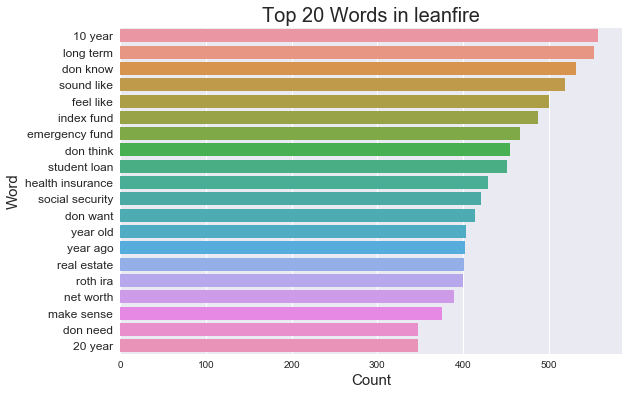

In [11]:
top_features = Xv_train_df.loc[1].sum().sort_values(ascending = False)[:20]

plt.figure(figsize = (9, 6))
plt.title('Top 20 Words in leanfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Count', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

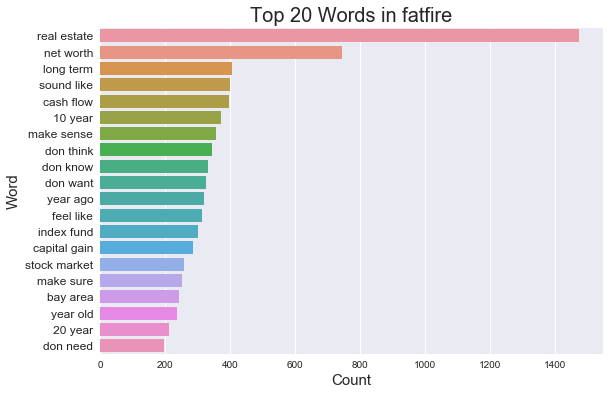

In [12]:
top_features = Xv_train_df.loc[0].sum().sort_values(ascending = False)[:20]

plt.figure(figsize = (9, 6))
plt.title('Top 20 Words in fatfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Count', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

### Vectorize with TF-IDF

In [25]:
X_train.head()

126     ['a', 'reminder', 'on', 'good', 'posting', 'pr...
348     ['alternative', 'to', 'the', 'stock', 'market'...
1450    ['what', 'do', 'you', 'guy', 'do', 'for', 'hea...
1515    ['any', 'fatfire', 'story', 'from', 'europe'][...
1150    ['rental', 'property', 'and', 'tax']['i', 'm',...
dtype: object

In [14]:
# Instantiate Vectorizer
tfidf = TfidfVectorizer(analyzer = "word",   
                       tokenizer = None,    
                       ngram_range = (2, 2),
                       preprocessor = None, 
                       stop_words = custom_stop_words,   
                       max_features = 1000)

# Fit and Transform
Xtfidf_train = tfidf.fit_transform(X_train)
Xtfidf_test = tfidf.transform(X_test)

Xtfidf_train = Xtfidf_train.toarray()
Xtfidf_test = Xtfidf_test.toarray()

Xtfidf_train_df = pd.DataFrame(Xtfidf_train, columns = tfidf.get_feature_names())
Xtfidf_test_df = pd.DataFrame(Xtfidf_test, columns = tfidf.get_feature_names())

Xtfidf_train_df.index = y_train
Xtfidf_test_df.index = y_test

print(Xtfidf_train_df.shape)
Xtfidf_train_df.head()

(1322, 1000)


,000 000,000 month,000 year,10 000,10 15,10 20,10 million,10 month,10 year,100 000,...,year tax,year think,year time,year ve,year wa,year want,year work,year working,year worth,year year
subreddit_leanfire,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062761
0,0.0,0.0,0.0,0.0,0.000000,0.140028,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0,0.0,0.0,0.0,0.0,0.090986,0.000000,0.05652,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


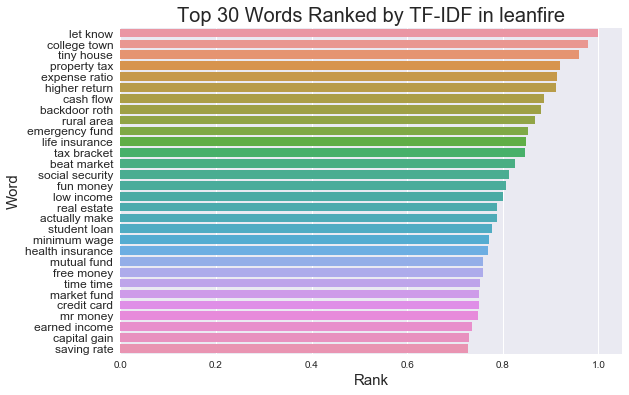

In [12]:
top_n = 30
top_features = Xtfidf_train_df.loc[1].max().sort_values(ascending = False)[:top_n]

plt.figure(figsize = (9, 6))
plt.title(f'Top {top_n} Words Ranked by TF-IDF in leanfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Rank', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

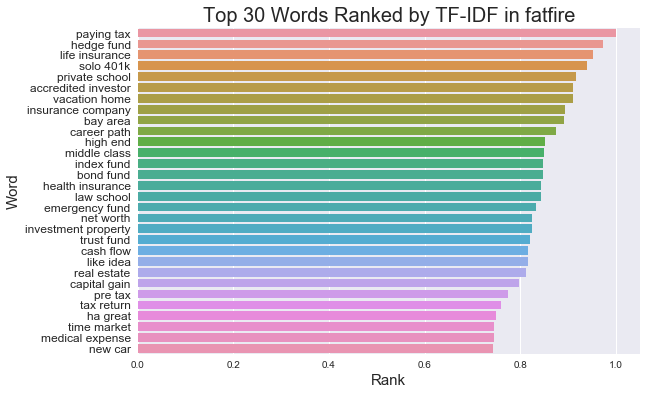

In [13]:
top_n = 30
top_features = Xtfidf_train_df.loc[0].max().sort_values(ascending = False)[:top_n]

plt.figure(figsize = (9, 6))
plt.title(f'Top {top_n} Words Ranked by TF-IDF in fatfire', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Rank', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

It appears that `/r/leanfire` posts tend to talk more about living in a tiny house, rural area, expense ratio, saving rate; lifestyles that involve **minimizing cost of living**. `/r/fatfire` posts more about vacation home, bay area, investment property, law school, new car; life styles that involve a **high cost of living**.

### Instantiate all models

In [14]:
classifier_models = {
    'LogisticRegression' : LogisticRegression(),
    'KNN': KNeighborsClassifier(), 
    'NaiveBayes' : MultinomialNB(),
    'DecisionTree' : DecisionTreeClassifier(random_state = 42), 
    'BaggedDecisionTree' : BaggingClassifier(random_state = 42),
    'RandomForest' : RandomForestClassifier(random_state = 42), 
    'ExtraTrees' : ExtraTreesClassifier(random_state = 42), 
    'AdaBoost' : AdaBoostClassifier(random_state=42), 
#     'GradientBoosting' : GradientBoostingClassifier(random_state = 42),
    'SVM' : SVC()
}

### Set up param_grid for GridSearching each model

In [15]:
classifier_model_params = {
    'LogisticRegression' : {
        'penalty' : ['l1', 'l2'],
        'C' : [.1, 1, 10] },
    'KNN' : {
        'n_neighbors' : [5, 9, 13, 17, 21] },
    'NaiveBayes' : {
        'alpha' : [.5, 1, 2]},
    'DecisionTree': {
        'max_depth' : [None, 6, 10, 14], 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [2, 3] },
    'BaggedDecisionTree' : {
        'n_estimators' : [20, 30, 40] },
    'RandomForest' : {
        'n_estimators' : [20, 30, 40],
        'max_depth' : [None, 2, 6, 10],
        'min_samples_split' : [2, 3, 4] },
    'ExtraTrees' : {
        'n_estimators' : [20, 30, 40],
        'max_depth' : [None, 6, 10, 14],
        'min_samples_leaf' : [1, 2], 
        'min_samples_split' : [2, 3], },
    'AdaBoost' : {
        'n_estimators' : [25, 50, 75],
        'learning_rate' : [0.9, 1.0] },
#     'GradientBoosting' : {
#         'n_estimators' : [100, 150],
#         'learning_rate' : [0.9, 1.0],
#         'max_depth' : [2, 3] },
    'SVM' : {
        'C' : [.5, 1, 2],
        'kernel' : ['rbf', 'linear'] }
}

### Define a function to GridSearch a model

In [16]:
def gridsearch_summary(X_train, X_test, y_train, y_test, model_name, model, model_params, problem = 'classification'):
    '''
    Arguments:
    X_train, X_test, y_train, y_test : vectorized train test split of X and y
    model_name : str name of model
    model : model constructor
        example: 'LogisticRegression' : LogisticRegression()
    model_params : dictionary of param_grids for GridSearch
        example: 'LogisticRegression' : {
                      'penalty' : ['l1', 'l2'],
                      'C' : [.1, 1, 10] }
    problem : str of problem type: 'classification' or 'regression'
    
    Return:
    summary_df : a single row DataFrame containing the GridSearch model and its 
              best model, predictions, and scores.
    '''   
    problem = problem.lower()
    
    if problem != 'regression' and problem != 'classification':
        print('Invalid problem type. Try "regression" or "classification"')
        return

    summary = {}

    # Track progress
    print(f'Fitting {model_name}')

    # GridSearch
    gs = GridSearchCVProgressBar(model, model_params, cv = 5)
    gs.fit(X_train, y_train)

    # Make predictions
    y_train_pred = gs.best_estimator_.predict(X_train)
    y_test_pred = gs.best_estimator_.predict(X_test)

    # Build summary
    summary['Model Name'] = model_name
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Best Score'] = gs.best_score_
    summary['Best Params'] = gs.best_params_
    summary['Best Estimator'] = gs.best_estimator_
    summary['Grid Search Model'] = gs

    if problem == 'regression':
        summary['Train Score'] = r2_score(y_train, y_train_pred)
        summary['Test Score'] = r2_score(y_test, y_test_pred)
    elif problem == 'classification':
        summary['Train Score'] = accuracy_score(y_train, y_train_pred)
        summary['Test Score'] = accuracy_score(y_test, y_test_pred)
    
    # Construct output dataframe 
    summary_df = pd.DataFrame([summary])

    # Rearrange columns
    summary_df = summary_df[['Model Name', 'Best Params', 'Best Score', 'Best Estimator',
                             'Train Score', 'Test Score', 'Train Pred', 'Test Pred', 'Grid Search Model']]
        
    return summary_df

### Run each model with default hyperparameters

#### With CountVectorizer

In [17]:
summaries = []

for model_name, model in classifier_models.items():
    summary = {}
    
    print(f'Fitting {model_name}')
    model.fit(Xv_train, y_train)
    y_train_pred = model.predict(Xv_train)
    y_test_pred = model.predict(Xv_test)

    # K-Folds Cross Validation
    kf = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)
    
    summary['Model Name'] = model_name
    summary['Model'] = model
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Train Score'] = model.score(Xv_train, y_train)
    summary['Test Score'] = model.score(Xv_test, y_test)
    summary['CV Score'] = cross_val_score(model, Xv_train, y_train, cv = kf).mean()

    summaries.append(summary)
    
benchmark_models_cv = pd.DataFrame(summaries)

Fitting LogisticRegression
Fitting KNN
Fitting NaiveBayes
Fitting DecisionTree
Fitting BaggedDecisionTree
Fitting RandomForest
Fitting ExtraTrees
Fitting AdaBoost
Fitting SVM


In [18]:
benchmark_models_cv[['Model Name', 'CV Score', 'Train Score', 'Test Score']]

,Model Name,CV Score,Train Score,Test Score
0,LogisticRegression,0.770010,0.993192,0.818594
1,KNN,0.679249,0.788200,0.648526
2,NaiveBayes,0.840408,0.874433,0.825397
3,DecisionTree,0.710259,0.999244,0.696145
4,BaggedDecisionTree,0.749567,0.992436,0.707483
5,RandomForest,0.751897,0.990923,0.734694
6,ExtraTrees,0.726902,0.999244,0.671202
7,AdaBoost,0.769993,0.847958,0.780045
8,SVM,0.754118,0.801815,0.739229


**Naive Bayes** (`MultinomialNB`) appears to be performing the best in terms of cross validated accuracy. The Tree models are severely overfit.

#### With TfidfVectorizer

In [19]:
summaries = []

for model_name, model in classifier_models.items():
    summary = {}
    
    print(f'Fitting {model_name}')
    model.fit(Xtfidf_train, y_train)
    y_train_pred = model.predict(Xtfidf_train)
    y_test_pred = model.predict(Xtfidf_test)

    # K-Folds Cross Validation
    kf = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)
    
    summary['Model Name'] = model_name
    summary['Model'] = model
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Train Score'] = model.score(Xtfidf_train, y_train)
    summary['Test Score'] = model.score(Xtfidf_test, y_test)
    summary['CV Score'] = cross_val_score(model, Xtfidf_train, y_train, cv = kf).mean()

    summaries.append(summary)
    
benchmark_models_tfidf = pd.DataFrame(summaries)

Fitting LogisticRegression
Fitting KNN
Fitting NaiveBayes
Fitting DecisionTree
Fitting BaggedDecisionTree
Fitting RandomForest
Fitting ExtraTrees
Fitting AdaBoost
Fitting SVM


In [20]:
benchmark_models_tfidf[['Model Name', 'CV Score', 'Train Score', 'Test Score']]

,Model Name,CV Score,Train Score,Test Score
0,LogisticRegression,0.811648,0.915280,0.823129
1,KNN,0.630793,0.640696,0.600907
2,NaiveBayes,0.830559,0.885023,0.823129
3,DecisionTree,0.686005,0.999244,0.675737
4,BaggedDecisionTree,0.755685,0.990923,0.741497
5,RandomForest,0.751122,0.994705,0.761905
6,ExtraTrees,0.754141,0.999244,0.748299
7,AdaBoost,0.751908,0.865356,0.764172
8,SVM,0.566496,0.566566,0.566893


**Naive Bayes** wins again. DecisionTree and ExtraTree reached perfect training predictions, but are even more overfit.

### Tune hyperparameters of each Classification model using GridSearch

#### With CountVectorizer

In [23]:
t0 = time.time()
gs_cv_summaries = pd.DataFrame()

for model_name, model in classifier_models.items():
    gs_cv_summaries = gs_cv_summaries.append(gridsearch_summary(Xv_train, Xv_test, y_train, y_test, 
                                               model_name, model, 
                                               classifier_model_params[model_name]), ignore_index = True)
time.time() - t0

Fitting LogisticRegression
[........................................] 100% | 1.01 sec | GridSearchCV 
Fitting KNN
[........................................] 100% | 53.77 sec | GridSearchCV 
Fitting NaiveBayes
[........................................] 100% | 0.26 sec | GridSearchCV 
Fitting DecisionTree
[........................................] 100% | 5.44 sec | GridSearchCV 
Fitting BaggedDecisionTree
[........................................] 100% | 25.96 sec | GridSearchCV 
Fitting RandomForest
[........................................] 100% | 16.19 sec | GridSearchCV 
Fitting ExtraTrees
[........................................] 100% | 28.88 sec | GridSearchCV 
Fitting AdaBoost
[........................................] 100% | 15.14 sec | GridSearchCV 
Fitting SVM
[........................................] 100% | 57.55 sec | GridSearchCV 


216.28527998924255

In [27]:
gs_cv_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']]

,Model Name,Best Params,Best Score,Train Score,Test Score
0,LogisticRegression,"{'C': 0.1, 'penalty': 'l2'}",0.795008,0.960666,0.818594
1,KNN,{'n_neighbors': 21},0.686082,0.738275,0.684807
2,NaiveBayes,{'alpha': 0.5},0.834342,0.875189,0.823129
3,DecisionTree,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.698941,0.997731,0.700680
4,BaggedDecisionTree,{'n_estimators': 30},0.770802,0.996974,0.727891
5,RandomForest,"{'max_depth': None, 'min_samples_split': 4, 'n...",0.792738,0.997731,0.789116
6,ExtraTrees,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.785930,0.999244,0.759637
7,AdaBoost,"{'learning_rate': 0.9, 'n_estimators': 75}",0.762481,0.880484,0.795918
8,SVM,"{'C': 2, 'kernel': 'rbf'}",0.783661,0.875946,0.791383


#### With TfidfVectorizer

In [28]:
t0 = time.time()
gs_tfidf_summaries = pd.DataFrame()

for model_name, model in classifier_models.items():
    gs_tfidf_summaries = gs_tfidf_summaries.append(gridsearch_summary(Xtfidf_train, Xtfidf_test, y_train, y_test, 
                                                                       model_name, model, 
                                                                       classifier_model_params[model_name]), 
                                                                       ignore_index = True)
time.time() - t0

Fitting LogisticRegression
[........................................] 100% | 0.57 sec | GridSearchCV 
Fitting KNN
[........................................] 100% | 61.40 sec | GridSearchCV 
Fitting NaiveBayes
[........................................] 100% | 0.20 sec | GridSearchCV 
Fitting DecisionTree
[........................................] 100% | 8.55 sec | GridSearchCV 
Fitting BaggedDecisionTree
[........................................] 100% | 48.28 sec | GridSearchCV 
Fitting RandomForest
[........................................] 100% | 18.57 sec | GridSearchCV 
Fitting ExtraTrees
[........................................] 100% | 29.50 sec | GridSearchCV 
Fitting AdaBoost
[........................................] 100% | 20.73 sec | GridSearchCV 
Fitting SVM
[........................................] 100% | 72.79 sec | GridSearchCV 


274.57068705558777

In [29]:
gs_tfidf_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']]

,Model Name,Best Params,Best Score,Train Score,Test Score
0,LogisticRegression,"{'C': 10, 'penalty': 'l2'}",0.813918,0.979576,0.829932
1,KNN,{'n_neighbors': 21},0.789713,0.801059,0.741497
2,NaiveBayes,{'alpha': 0.5},0.835098,0.886536,0.823129
3,DecisionTree,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.704236,0.781392,0.684807
4,BaggedDecisionTree,{'n_estimators': 40},0.770802,0.997731,0.757370
5,RandomForest,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.799546,0.896369,0.768707
6,ExtraTrees,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.794251,0.999244,0.768707
7,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 75}",0.757943,0.916793,0.786848
8,SVM,"{'C': 1, 'kernel': 'linear'}",0.816944,0.937216,0.823129


### VotingClassifier

#### With CountVectorizer

In [30]:
vote = VotingClassifier(
    [(model_name, model) for model_name, model in classifier_models.items()]
)
vote.fit(Xv_train, y_train)

VotingClassifier(estimators=[('LogisticRegression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [31]:
t0 = time.time()
print(cross_val_score(vote, Xv_train, y_train, cv = kf).mean())
time.time() - t0

0.8138869902027797


32.477360248565674

In [32]:
print('Train Score:', vote.score(Xv_train, y_train))
print('Test Score:', vote.score(Xv_test, y_test))

Train Score: 0.9969742813918305
Test Score: 0.8049886621315193


#### With TfidfVectorizer

In [33]:
t0 = time.time()
print(cross_val_score(vote, Xtfidf_train, y_train, cv = kf).mean())
time.time() - t0

0.8086010480747323


41.75851392745972

In [34]:
vote.fit(Xtfidf_train, y_train)
print('Train Score:', vote.score(Xtfidf_train, y_train))
print('Test Score:', vote.score(Xtfidf_test, y_test))

Train Score: 0.9795763993948563
Test Score: 0.7868480725623582


`VotingClassifier` appears to perform better with CountVectorizer.

### Evaluation and Conceptual Understanding

`TfidfVectorizer` tends to produce more accurate models than `CountVectorizer`. The top features generated from `TfidfVectorizer` also tend to be more meaningful. 

Unseen data will be newly submitted posts on `/r/leanfire`, meaning all new data belongs to the positive class (`y=1`). If the model classifies a post as negative (`y=0`), then it is likely to be spam.  

True Positives = Ham  
False Negative = Spam  

To maintain the integrity of the subreddit, I prefer the model to have a **sufficiently high False Negative rate** (spam detection rate). The consequence of this decision is that **some quality posts may be blocked**. This is preferred over **letting actual spam bypass the detection algorithm**. 
